# DDM for All Control Data

Parse all control data to a single CSV, then check if subject data can fit a hierarchical drift decision model for different stimuli types

Experimental stimuli are as follows:  
- Condition 1: Same stimuli (see cat / hear cat) -- `SS`  
- Condition 2: Phonologically congruent (see cat / hear hat) -- `CP`  
- Condition 3: Semantically congruent (see cat / hear dog) -- `CS`  
- Condition 4: Unrelated stimuli (see house / hear cat)  -- `US`  

### Parse all subject data to single csv

Generate a single csv for all data, using `subject_idx` as a unique patient identifier. 
Also give conditions (`stim`) a 2-character descriptive instead of a number.

CSV fields are as follows:  
- `subj_idx`: Unique subject identifier  
- `rt`: Reaction time  
- `stim`: Stimulus (SS/CP/CS/US)  
- `response`: Response to stimulus (True(1)/False(0))  

In [1]:
def parse_condition(stim_num):
    if stim_num == '1':
        return 'SS'
    if stim_num == '2':
        return 'CP'
    if stim_num == '3':
        return 'CS'
    if stim_num == '4':
        return 'US'

In [2]:
import csv
import glob 


csv_dir = '../data/pilot_subjects/'
subjects = []

for csv_file in glob.glob(csv_dir + 'data*.csv'):
    subject = []
    subj_idx = csv_file[-9:-4]  # Use id from filename
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for trial in reader:
            trial['subj_idx'] = subj_idx
            trial['stim'] = parse_condition(trial['stim'])
            subject.append(trial)
    subjects.append(subject)
    
keys = subject[0].keys()

with open('../data/controls.csv', 'w') as out:
        writer = csv.DictWriter(out, keys)
        writer.writeheader()
        for subj in subjects:
            writer.writerows(subj)

## First stab at hddm model fit

In [57]:
import hddm

data = hddm.load_csv('../data/all_subjects_clean.csv')

model = hddm.HDDM(data, depends_on={'v': 'stim'})
model.find_starting_values()
model.sample(6000, burn=20)

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 6000 of 6000 complete in 262.5 sec

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [4]:
model.print_stats()

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                       mean        std       2.5q        25q        50q        75q      97.5q       mc err
a                   2.39576   0.152745    2.11016    2.29443    2.38941    2.49211    2.70333   0.00293055
a_std              0.569545   0.131783   0.370306   0.476155   0.552084   0.638271   0.876005   0.00298082
a_subj.17991        3.52977   0.241075    3.07717    3.36491    3.52228    3.68512    4.02475   0.00614853
a_subj.18288        2.38022   0.166946    2.07213     2.2667    2.37259     2.4832    2.72905    0.0044411
a_subj.18325        2.78442   0.257057    2.34213    2.60079    2.76479    2.94589    3.33576   0.00919474
a_subj.18333        2.28053   0.158222    1.98841    2.16915    2.27378    2.38402    2.60762   0.00441611
a_subj.18334        2.41955   0.240204    2.01519    2.25344     2.4054    2.56443    2.94104    0.0108646
a_subj.18350        1.62973   0.126326    1.40939    1.54025    1.62021    1.71136    1.89883   0.00414609
a_subj.18547        1.74868    0.1150

##### Parameters of Interest

- Mean of *a* = 2.39576 (std = 0.152745)  
- Mean of *t* = 0.576694 s  
- Dift rate (v) mean values:  
    - CP = 1.47559  
    - CS = 1.95786  
    - SS = 2.37192  
    - US = 2.28449

#### Plot posteriors

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std


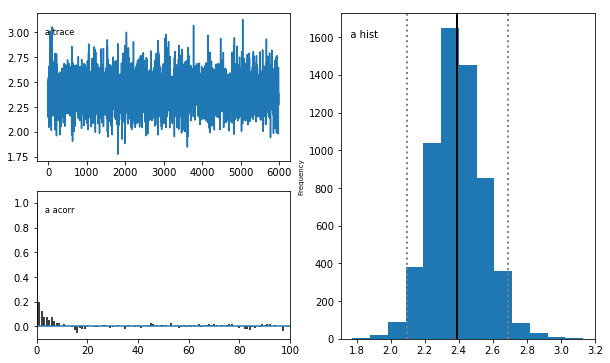

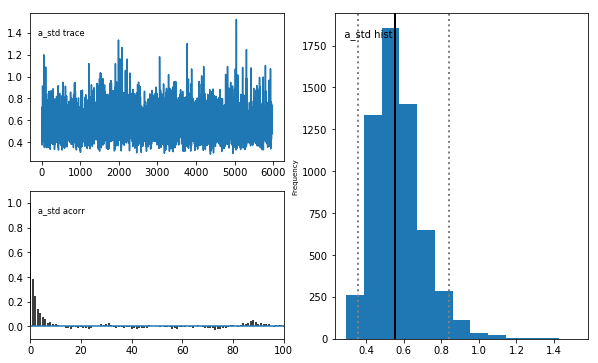

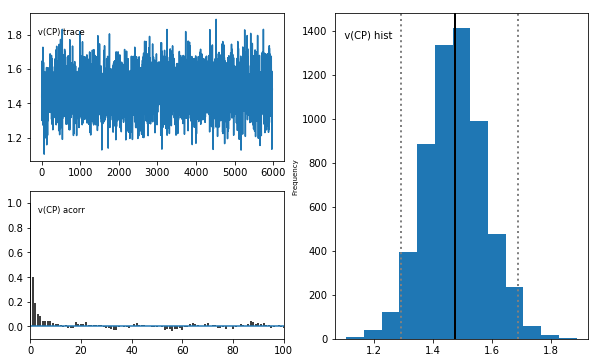

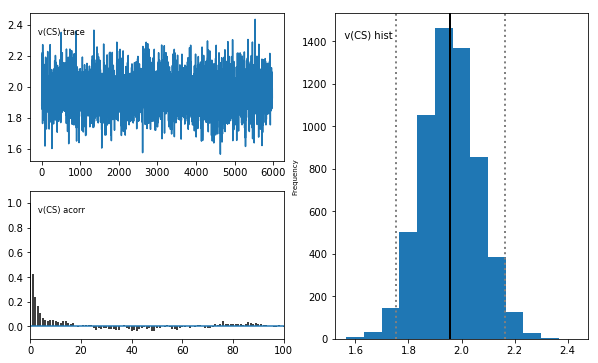

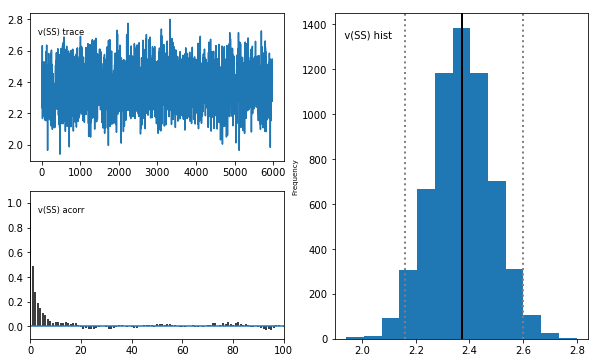

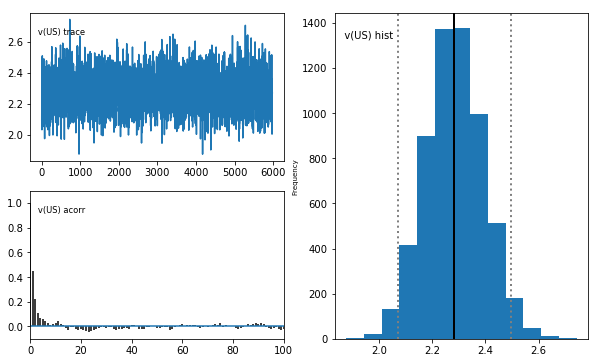

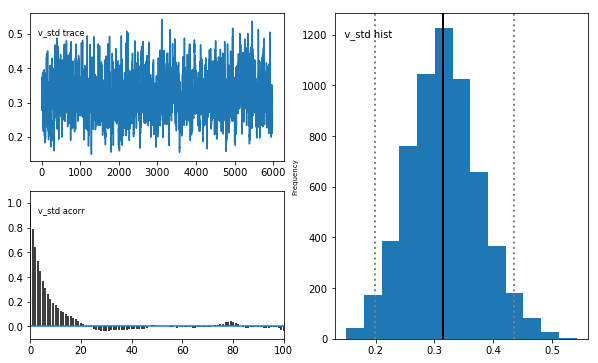

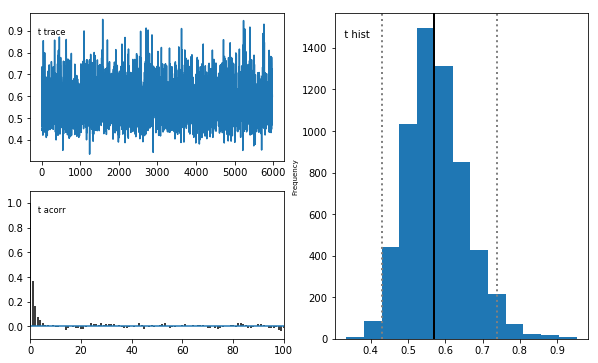

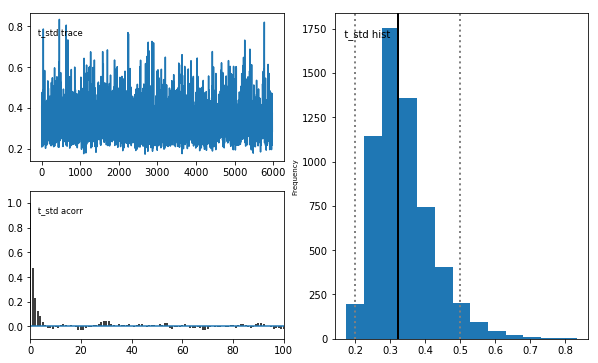

In [5]:
%matplotlib inline
model.plot_posteriors()

#### Plot posterior of drift rate for group means

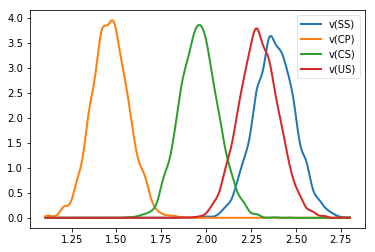

In [6]:
v_SS, v_CP, v_CS, v_US = model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

Calculate the proportion of the posteriors in which the drift rate for one condition is greater than the other

In [7]:
print('P(SS > US) = ' + str((v_SS.trace() > v_US.trace()).mean()))
print('P(CP > SS) = ' + str((v_CP.trace() > v_SS.trace()).mean()))
print('P(CS > SS) = ' + str((v_CS.trace() > v_SS.trace()).mean()))
print('P(CP > CS) = ' + str((v_CP.trace() > v_CS.trace()).mean()))

P(SS > US) = 0.732775919732
P(CP > SS) = 0.0
P(CS > SS) = 0.00317725752508
P(CP > CS) = 0.000334448160535


Therefore:  
- The drift rate for **CP** is significantly lower than all other conditions  
- The drift rate for **CS** is significantly lower than **SS** and **US**, but significantly higher than **CP**  
- The drift rates for **SS** and **US** are not significantly different  

#### Check for model convergence 

In [8]:
models = []
for i in range(5):
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models)

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 6000 of 6000 complete in 282.5 sec

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


 [-----------------100%-----------------] 6000 of 6000 complete in 288.0 sec

{'a': 1.0004683770473366,
 'a_std': 1.0002930367583327,
 'a_subj.17991': 1.001475241554985,
 'a_subj.18288': 1.00092312622369,
 'a_subj.18325': 1.0000252899656865,
 'a_subj.18333': 1.0007237292037425,
 'a_subj.18334': 1.00202574301105,
 'a_subj.18350': 1.0015561857856901,
 'a_subj.18547': 1.0010168368145353,
 'a_subj.18619': 1.0023487766454109,
 'a_subj.18864': 1.0012664896806938,
 'a_subj.18919': 1.0010460888207739,
 'a_subj.18977': 1.0001279858651633,
 'a_subj.18978': 1.0009727221719167,
 'a_subj.18979': 1.0016689381274646,
 'a_subj.18988': 1.0006127559993909,
 'a_subj.19686': 1.0013119973689844,
 'a_subj.19687': 1.0004030368439716,
 't': 1.0001107976800878,
 't_std': 1.0003376375312927,
 't_subj.17991': 1.0014506128897218,
 't_subj.18288': 1.0008179323041115,
 't_subj.18325': 0.99992223288578996,
 't_subj.18333': 1.0002265422954852,
 't_subj.18334': 1.0011238707268417,
 't_subj.18350': 1.0006157710018271,
 't_subj.18547': 1.0005955706915415,
 't_subj.18619': 1.0023289887817504,
 't_

Models converge!

## Explore Bias

In [65]:
model_bias = hddm.HDDM(data, depends_on={'v': 'stim', 'z': 'stim'}, bias=True)
model_bias.find_starting_values()
model_bias.sample(6000, burn=20)

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 6000 of 6000 complete in 411.5 sec

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std
Plotting z(CP)
Plotting z(CS)
Plotting z(SS)
Plotting z(US)
Plotting z_std


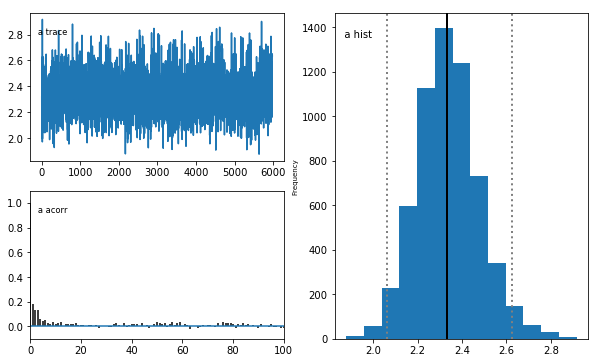

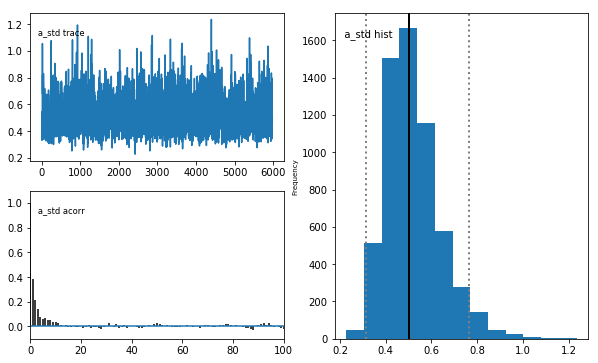

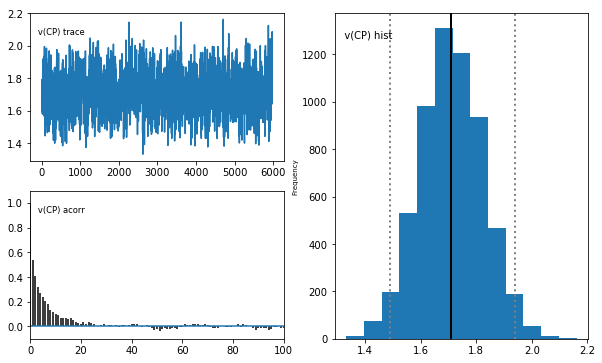

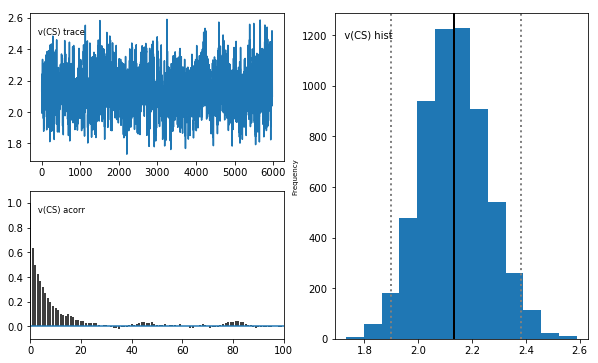

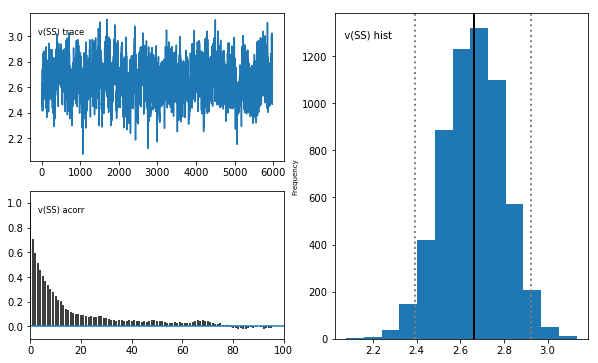

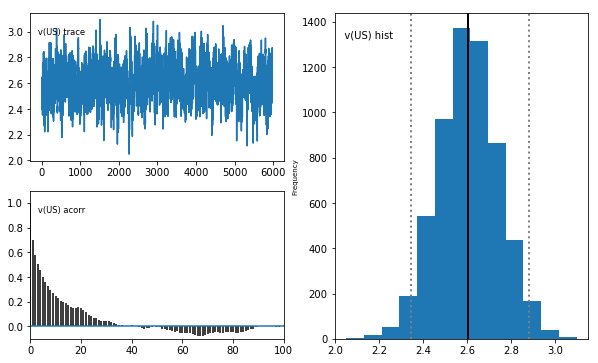

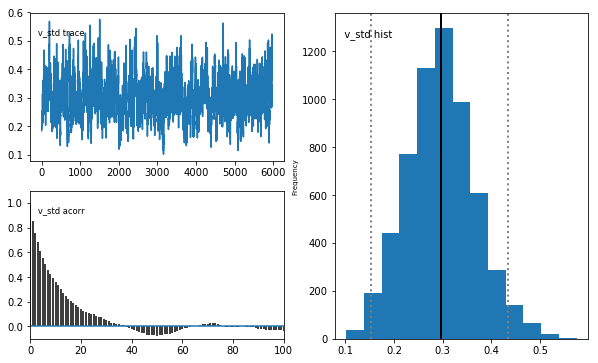

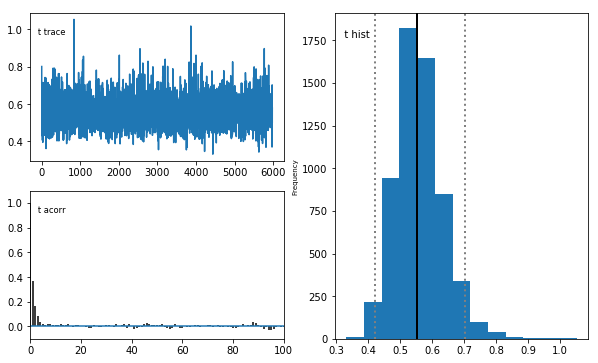

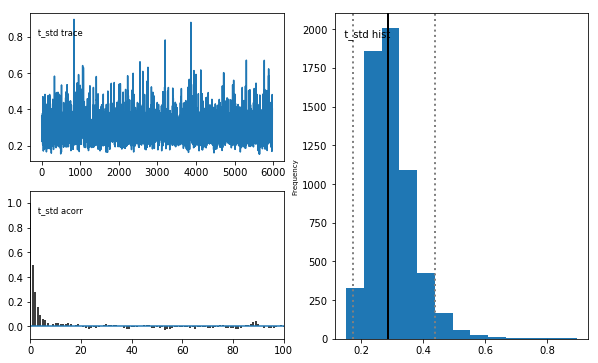

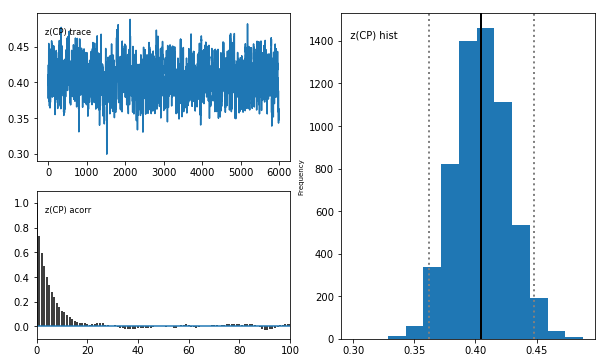

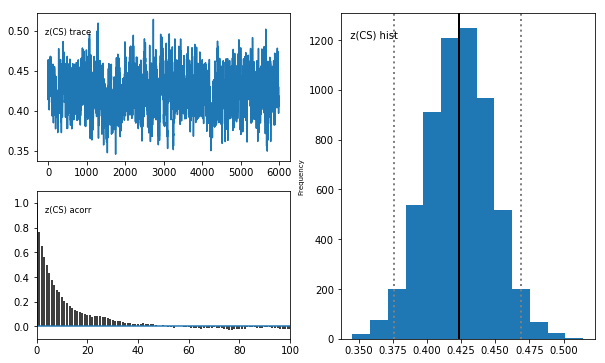

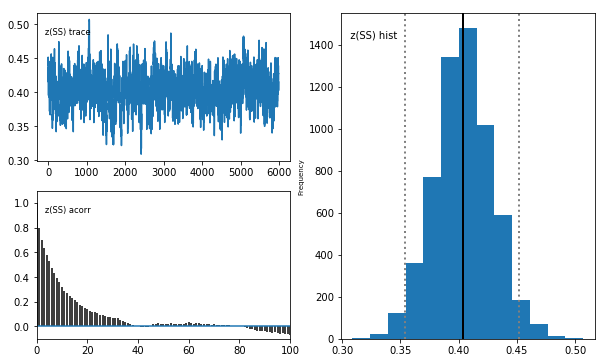

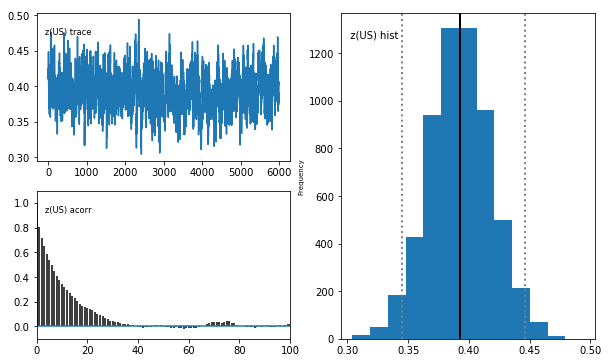

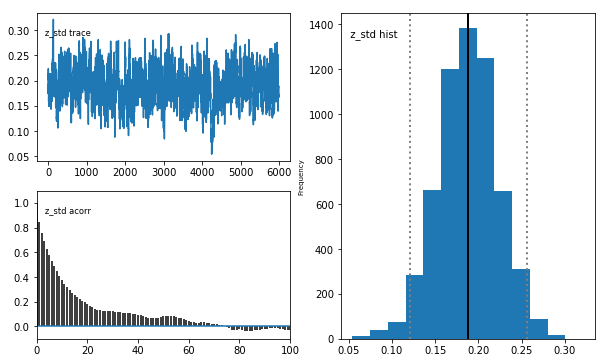

In [67]:
model_bias.plot_posteriors()

In [66]:
model_bias.print_stats()

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                      mean        std       2.5q        25q        50q        75q     97.5q       mc err
a                  2.33775   0.140992     2.0755    2.24308    2.33155     2.4236   2.64166   0.00300188
a_std             0.519316   0.121337    0.33484   0.435395   0.500567   0.582782  0.813579    0.0028198
a_subj.17991       3.22999   0.220317    2.82623    3.07389    3.22144    3.37386   3.67497   0.00629581
a_subj.18288       2.33037   0.160563    2.03794    2.21719    2.32306    2.43105   2.66471   0.00469429
a_subj.18325       2.77405   0.249531    2.33017     2.5988    2.75544    2.93424   3.31491   0.00990998
a_subj.18333       2.23933   0.152266    1.95872     2.1342    2.23458    2.33865    2.5627   0.00405877
a_subj.18334       2.33158   0.206306    1.96268    2.19038    2.31886    2.46151   2.77322   0.00755267
a_subj.18350       1.58352   0.119376    1.37997    1.49713     1.5748    1.65904   1.84513   0.00414128
a_subj.18547       1.68415   0.113893    1.47827    1.6

In [70]:
model_bias.print_stats()

/Users/celefthe/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                      mean        std       2.5q        25q        50q        75q     97.5q       mc err
a                  2.33775   0.140992     2.0755    2.24308    2.33155     2.4236   2.64166   0.00300188
a_std             0.519316   0.121337    0.33484   0.435395   0.500567   0.582782  0.813579    0.0028198
a_subj.17991       3.22999   0.220317    2.82623    3.07389    3.22144    3.37386   3.67497   0.00629581
a_subj.18288       2.33037   0.160563    2.03794    2.21719    2.32306    2.43105   2.66471   0.00469429
a_subj.18325       2.77405   0.249531    2.33017     2.5988    2.75544    2.93424   3.31491   0.00990998
a_subj.18333       2.23933   0.152266    1.95872     2.1342    2.23458    2.33865    2.5627   0.00405877
a_subj.18334       2.33158   0.206306    1.96268    2.19038    2.31886    2.46151   2.77322   0.00755267
a_subj.18350       1.58352   0.119376    1.37997    1.49713     1.5748    1.65904   1.84513   0.00414128
a_subj.18547       1.68415   0.113893    1.47827    1.6

z values don't appear to significantly vary